# TP 2 – Modele de Black Scholes et Monte Carlo

Dans ce TP, nous allons:
- dériver pas a pas la formule de Black Scholes en partant de l'equation differentielle stochastique (EDS);
- interpreter la formule sous forme d'esperance risque neutre;
- comparer le resultat analytique a une approximation Monte Carlo;
- utiliser les fonctions de pricing analytique de fypy.


In [1]:
# Imports pour le TP
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from fypy.pricing.analytical.black_scholes import black_scholes_price

%matplotlib inline

/tmp/ipykernel_9301/528842907.py:4: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.3.4)
  from scipy.stats import norm


## 1. Modele de diffusion lognormale

Nous modelisons le prix d'une action \( S_t \) par une EDS de type **geometric Brownian motion**:
\[
dS_t = \mu S_t \, dt + \sigma S_t \, dW_t,
\]
ou:
- \( \mu \) est le drift (taux de croissance moyen);
- \( \sigma > 0 \) est la volatilite;
- \( W_t \) est un mouvement brownien standard.

Sous la mesure risque neutre \( \mathbb{Q} \), le drift doit etre le **taux sans risque net des dividendes**:
\[
dS_t = (r - q) S_t \, dt + \sigma S_t \, dW_t^{\mathbb{Q}},
\]
ou \( r \) est le taux sans risque continu, et \( q \) le rendement de dividende continu.

### 1.1. Dérivons la loi de \( S_T \)

1. Partons de l'EDS sous \( \mathbb{Q} \):
   \[
   dS_t = (r - q) S_t \, dt + \sigma S_t \, dW_t.
   \]
2. On applique la formule d'Ito a la fonction \( f(S_t) = \ln S_t \). On obtient:
   \[
   d \ln S_t = \left( (r - q) - \tfrac{1}{2} \sigma^2 \right) dt + \sigma \, dW_t.
   \]
3. On integre entre 0 et \( T \):
   \[
   \ln S_T - \ln S_0 = \left( (r - q) - \tfrac{1}{2} \sigma^2 \right) T + \sigma W_T.
   \]
4. Comme \( W_T \sim \mathcal{N}(0, T) \), on peut ecrire \( W_T = \sqrt{T} Z \) avec \( Z \sim \mathcal{N}(0,1) \).
   On obtient alors:
   \[
   \ln S_T = \ln S_0 + \left( (r - q) - \tfrac{1}{2} \sigma^2 \right) T + \sigma \sqrt{T} Z.
   \]

Donc \( \ln S_T \) est gaussien, et \( S_T \) est lognormal sous \( \mathbb{Q} \).

## 2. Formule de Black Scholes pour un call europeen

On considere un call europeen de strike \( K \) et d'echeance \( T \). Son payoff a l'echeance est:
\[
X = (S_T - K)^+ = \max(S_T - K, 0).
\]

Sous la mesure risque neutre, le prix aujourd'hui \( C_0 \) s'ecrit:
\[
C_0 = e^{-r T} \, \mathbb{E}^{\mathbb{Q}}[ (S_T - K)^+ ].
\]

L'idee est de **calculer cette esperance explicitement** grace a la loi lognormale de \( S_T \).

### 2.1. Etapes de la derivation

1. On introduit le forward risque neutre \( F_0(T) \) de l'action:
   \[
   F_0(T) = S_0 e^{(r - q) T}.
   \]
   C'est exactement ce que donne la classe `EquityForward` du TP precedent.
2. On note \( v = \sigma \sqrt{T} \) (la volatilite term structure sur \([0,T]\)).
3. De la section precedente, on a:
   \[
   \ln S_T = \ln F_0(T) - \tfrac{1}{2} v^2 + v Z,
   \]
   ce qui revient a centrer la loi autour du forward.
4. On pose alors
   \[
   d_1 = \frac{\ln(F_0(T) / K) + \tfrac{1}{2} v^2}{v}, \quad
   d_2 = d_1 - v.
   \]
5. On peut montrer (integrales sur la densite gaussienne) que:
   \[
   C_0 = e^{-r T} \big( F_0(T) N(d_1) - K N(d_2) \big),
   \]
   ou \( N(\cdot) \) est la fonction de repartition de la loi normale standard.

C'est la forme classique de la formule de Black Scholes pour un call forward. Pour le **call spot** avec dividendes,
fypy utilise exactement cette idee en travaillant avec le forward \( F_0(T) \).

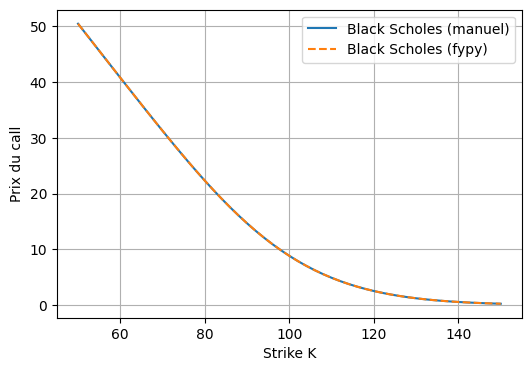

Erreur absolue maximale entre la formule manuelle et fypy : 0.0


In [2]:
# Implementation manuelle de la formule du call de Black Scholes
def prix_bs_manuel(S, K, is_call, sigma, r, q, T):
    disc = np.exp(-r * T)
    div_disc = np.exp(-q * T)
    F = S * div_disc / disc

    v = sigma * np.sqrt(T)
    d1 = (np.log(F / K) + 0.5 * v * v) / v
    d2 = d1 - v

    if is_call:
        return disc * (F * norm.cdf(d1) - K * norm.cdf(d2))
    return disc * (K * norm.cdf(-d2) - F * norm.cdf(-d1))

# Parametres de base
S0 = 100.0
r = 0.03
q = 0.01
sigma = 0.2
T = 1.0

disc = np.exp(-r * T)
div_disc = np.exp(-q * T)

K = np.linspace(50.0, 150.0, 51)

prix_manuel = prix_bs_manuel(S=S0, K=K, is_call=True, sigma=sigma, r=r, q=q, T=T)
prix_fypy = black_scholes_price(S=S0, K=K, is_call=True, vol=sigma, disc=disc, T=T, div_disc=div_disc)

plt.figure(figsize=(6, 4))
plt.plot(K, prix_manuel, label='Black Scholes (manuel)')
plt.plot(K, prix_fypy, '--', label='Black Scholes (fypy)')
plt.xlabel('Strike K')
plt.ylabel('Prix du call')
plt.legend()
plt.grid(True)
plt.show()

erreur_max = np.max(np.abs(prix_manuel - prix_fypy))
print('Erreur absolue maximale entre la formule manuelle et fypy :', erreur_max)

On constate que l'implementation analytique de fypy coincide avec notre derivation manuelle, a quelques erreurs
numeriques d'arrondi pres.

## 3. Approximation Monte Carlo de la formule de Black Scholes

Pour verifier numeriquement la formule, on peut simuler la trajectoire finale \( S_T \) et approximer
\( C_0 = e^{-rT} \mathbb{E}^{\mathbb{Q}}[(S_T - K)^+] \) par une moyenne empirique.

### 3.1. Simulation exacte de \( S_T \)

Comme on connait la loi de \( S_T \), on peut simuler directement:
\[
S_T = S_0 \exp\left( (r - q - \tfrac{1}{2} \sigma^2) T + \sigma \sqrt{T} Z \right), \quad Z \sim \mathcal{N}(0,1).
\]

Ensuite, on calcule le payoff \( (S_T - K)^+ \) sur chaque trajectoire, puis on moyenne.

In [3]:
# Simulation Monte Carlo de S_T et pricing du call
def prix_mc_call(S0, K, sigma, r, q, T, n_paths, seed=None):
    if seed is not None:
        np.random.seed(seed)

    Z = np.random.randn(n_paths)
    drift = (r - q - 0.5 * sigma * sigma) * T
    diffusion = sigma * np.sqrt(T) * Z
    S_T = S0 * np.exp(drift + diffusion)

    payoff = np.maximum(S_T - K, 0.0)
    prix = np.exp(-r * T) * np.mean(payoff)
    err_std = np.exp(-r * T) * np.std(payoff) / np.sqrt(n_paths)
    return prix, err_std

K0 = 100.0
n_paths = 100000

prix_mc, err_mc = prix_mc_call(S0=S0, K=K0, sigma=sigma, r=r, q=q, T=T, n_paths=n_paths, seed=42)
prix_bs = prix_bs_manuel(S=S0, K=K0, is_call=True, sigma=sigma, r=r, q=q, T=T)

print('Prix BS analytique  :', prix_bs)
print('Prix Monte Carlo    :', prix_mc)
print('Erreur statistique (ecart type / racine(n)) :', err_mc)

Prix BS analytique  : 8.827321225352126
Prix Monte Carlo    : 8.848643871185235
Erreur statistique (ecart type / racine(n)) : 0.043237614547167125


En augmentant le nombre de trajectoires, le prix Monte Carlo se rapproche du prix analytique (loi des grands nombres).
La quantite `err_std` donne un ordre de grandeur de l'incertitude statistique de l'estimateur Monte Carlo.

## 4. Remarque sur le module Monte Carlo de fypy

Le module `fypy.pricing.montecarlo` generalise ce type de simulation:
- `Diffusion1D` decrit une diffusion de dimension 1, via ses fonctions `mu_dt` et `sigma_dt`;
- `DiffusionStochasticProcess` emballe une diffusion dans un objet `StochasticProcess` generique;
- `MonteCarloEngine` gere l'evolution du processus et le stockage des trajectoires;
- `TrajectoryPricer` permet de transformer une trajectoire en prix (par exemple, options de chemin, options asiatiques, etc.).

Dans ce TP, nous avons volontairement code une version minimale du Monte Carlo pour bien voir le lien direct avec la
formule analytique. Dans les TPs suivants, nous exploiterons davantage les outils generiques de fypy pour
des modeles plus complexes (Levy, volatilite stochastique, etc.).